# Model Validation

## Section VI: Verification and Validation

This notebook validates the discrete-event simulation against analytical M/M/1 queuing theory.  
We will:
1. Calculate analytical M/M/1 metrics for each server tier
2. Compare simulation results with theoretical predictions
3. Perform statistical tests to verify accuracy
4. Assess model validity across different load conditions
5. Identify sources of discrepancy and model limitations

In [3]:
import sys
!{sys.executable} -m pip install simpy

  Using cached simpy-4.1.1-py3-none-any.whl.metadata (6.1 kB)
Using cached simpy-4.1.1-py3-none-any.whl (27 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import required libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import simpy
import numpy as np

# Add src directory to path
sys.path.insert(0, os.path.abspath('../src'))

from simulation import run_simulation, run_multiple_replications
from outputs import (
    aggregate_replications,
    calculate_confidence_intervals,
    analytical_mm1_metrics,
    compare_with_analytical
)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Analytical M/M/1 Formulas

For an M/M/1 queue with arrival rate λ and service rate μ:

- **Utilization**: ρ = λ / μ
- **Average number in system**: L = ρ / (1 - ρ)
- **Average time in system**: W = L / λ = 1 / (μ - λ)
- **Average queue length**: L_q = ρ² / (1 - ρ)
- **Average waiting time**: W_q = L_q / λ

**Note**: Without caching, requests flow sequentially through app server then DB server.

In [2]:
# Define system parameters
app_service_rate = 60  # req/min
db_service_rate = 30   # req/min

# Test arrival rates
test_arrival_rates = [5, 10, 15, 20, 25]

print("System Parameters:")
print(f"  Application Server Service Rate (μ_app): {app_service_rate} req/min")
print(f"  Database Server Service Rate (μ_db): {db_service_rate} req/min")
print(f"\nTest Arrival Rates (λ): {test_arrival_rates} req/min")

System Parameters:
  Application Server Service Rate (μ_app): 60 req/min
  Database Server Service Rate (μ_db): 30 req/min

Test Arrival Rates (λ): [5, 10, 15, 20, 25] req/min


## 2. Calculate Analytical Metrics

In [3]:
# Calculate analytical metrics for each arrival rate
analytical_results = []

for arrival_rate in test_arrival_rates:
    # App server metrics
    app_metrics = analytical_mm1_metrics(arrival_rate, app_service_rate)
    
    # DB server metrics (without cache, all requests go to DB)
    db_metrics = analytical_mm1_metrics(arrival_rate, db_service_rate)
    
    analytical_results.append({
        'arrival_rate': arrival_rate,
        'app_utilization': app_metrics['utilization'],
        'app_avg_queue_length': app_metrics['avg_queue_length'],
        'app_avg_response_time': app_metrics['avg_response_time'],
        'db_utilization': db_metrics['utilization'],
        'db_avg_queue_length': db_metrics['avg_queue_length'],
        'db_avg_response_time': db_metrics['avg_response_time'],
        'end_to_end_time': app_metrics['avg_response_time'] + db_metrics['avg_response_time']
    })

analytical_df = pd.DataFrame(analytical_results)

print("Analytical M/M/1 Predictions:")
print("=" * 100)
analytical_df

Analytical M/M/1 Predictions:


,arrival_rate,app_utilization,app_avg_queue_length,app_avg_response_time,db_utilization,db_avg_queue_length,db_avg_response_time,end_to_end_time
0,5,0.083333,0.007576,0.018182,0.166667,0.033333,0.040000,0.058182
1,10,0.166667,0.033333,0.020000,0.333333,0.166667,0.050000,0.070000
2,15,0.250000,0.083333,0.022222,0.500000,0.500000,0.066667,0.088889
3,20,0.333333,0.166667,0.025000,0.666667,1.333333,0.100000,0.125000
4,25,0.416667,0.297619,0.028571,0.833333,4.166667,0.200000,0.228571


## 3. Run Simulation Experiments (Without Cache)

Run simulations without caching to match M/M/1 assumptions.

In [4]:
# Run simulations for each arrival rate
simulation_results = []

for arrival_rate in test_arrival_rates:
    print(f"\nRunning simulation for λ = {arrival_rate} req/min...")
    
    # Run 10 replications
    results = run_multiple_replications(
        arrival_rate=arrival_rate,
        num_replications=10,
        app_service_rate=app_service_rate,
        db_service_rate=db_service_rate,
        simulation_time=120,  # Longer simulation for better accuracy
        cache_enabled=False   # No cache for M/M/1 validation
    )
    
    # Aggregate results
    df = aggregate_replications(results)
    summary = calculate_confidence_intervals(df)
    
    simulation_results.append({
        'arrival_rate': arrival_rate,
        'app_utilization': summary[summary['metric'] == 'app_utilization']['mean'].values[0],
        'app_avg_queue_length': summary[summary['metric'] == 'app_avg_queue_length']['mean'].values[0],
        'app_avg_response_time': summary[summary['metric'] == 'app_avg_response_time']['mean'].values[0],
        'db_utilization': summary[summary['metric'] == 'db_utilization']['mean'].values[0],
        'db_avg_queue_length': summary[summary['metric'] == 'db_avg_queue_length']['mean'].values[0],
        'db_avg_response_time': summary[summary['metric'] == 'db_avg_response_time']['mean'].values[0],
        'end_to_end_time': summary[summary['metric'] == 'system_avg_end_to_end_time']['mean'].values[0]
    })
    
    print(f"  Completed. Avg end-to-end time: {simulation_results[-1]['end_to_end_time']:.4f} min")

simulation_df = pd.DataFrame(simulation_results)

print("\n" + "=" * 100)
print("Simulation Results (10 replications each):")
print("=" * 100)
simulation_df


Running simulation for λ = 5 req/min...
  Completed. Avg end-to-end time: 0.0585 min

Running simulation for λ = 10 req/min...
  Completed. Avg end-to-end time: 0.0687 min

Running simulation for λ = 15 req/min...
  Completed. Avg end-to-end time: 0.0886 min

Running simulation for λ = 20 req/min...
  Completed. Avg end-to-end time: 0.1256 min

Running simulation for λ = 25 req/min...
  Completed. Avg end-to-end time: 0.2287 min

Simulation Results (10 replications each):


,arrival_rate,app_utilization,app_avg_queue_length,app_avg_response_time,db_utilization,db_avg_queue_length,db_avg_response_time,end_to_end_time
0,5,0.084346,0.007746,0.018252,0.167376,0.033700,0.040290,0.058542
1,10,0.167081,0.034190,0.019966,0.331081,0.159930,0.048707,0.068676
2,15,0.252408,0.086413,0.022375,0.497772,0.502739,0.066221,0.088597
3,20,0.332971,0.166349,0.024956,0.661107,1.353055,0.100673,0.125626
4,25,0.420780,0.306272,0.028824,0.827887,4.215680,0.199838,0.228671


## 4. Compare Simulation vs Analytical Results

In [13]:
# Calculate percentage errors
comparison_data = []

metrics_to_compare = [
    ('app_utilization', 'App Server Utilization'),
    ('app_avg_queue_length', 'App Server Queue Length'),
    ('app_avg_response_time', 'App Server Response Time'),
    ('db_utilization', 'DB Server Utilization'),
    ('db_avg_queue_length', 'DB Server Queue Length'),
    ('db_avg_response_time', 'DB Server Response Time'),
    ('end_to_end_time', 'End-to-End Time')
]

for arrival_rate in test_arrival_rates:
    analytical_row = analytical_df[analytical_df['arrival_rate'] == arrival_rate].iloc[0]
    simulation_row = simulation_df[simulation_df['arrival_rate'] == arrival_rate].iloc[0]
    
    for metric_name, display_name in metrics_to_compare:
        analytical_val = analytical_row[metric_name]
        simulation_val = simulation_row[metric_name]
        
        if analytical_val != 0:
            percent_error = abs((simulation_val - analytical_val) / analytical_val) * 100
        else:
            percent_error = 0
        
        comparison_data.append({
            'Arrival Rate': arrival_rate,
            'Metric': display_name,
            'Analytical': analytical_val,
            'Simulation': simulation_val,
            'Absolute Error': abs(simulation_val - analytical_val),
            'Percent Error (%)': percent_error
        })

comparison_df = pd.DataFrame(comparison_data)

print("\nDetailed Comparison (Simulation vs Analytical):")
print("=" * 120)
comparison_df.head(20)


Detailed Comparison (Simulation vs Analytical):


,Arrival Rate,Metric,Analytical,Simulation,Absolute Error,Percent Error (%)
0,5,App Server Utilization,0.083333,0.084346,0.001013,1.215275
1,5,App Server Queue Length,0.007576,0.007746,0.000170,2.241362
2,5,App Server Response Time,0.018182,0.018252,0.000070,0.385864
3,5,DB Server Utilization,0.166667,0.167376,0.000709,0.425389
4,5,DB Server Queue Length,0.033333,0.033700,0.000367,1.100498
5,5,DB Server Response Time,0.040000,0.040290,0.000290,0.725939
6,5,End-to-End Time,0.058182,0.058542,0.000360,0.618944
7,10,App Server Utilization,0.166667,0.167081,0.000414,0.248334
8,10,App Server Queue Length,0.033333,0.034190,0.000857,2.570634
9,10,App Server Response Time,0.020000,0.019966,0.000034,0.169863


In [6]:
# Summary statistics of errors
error_summary = comparison_df.groupby('Metric').agg({
    'Percent Error (%)': ['mean', 'std', 'max']
}).round(2)

error_summary.columns = ['Mean Error (%)', 'Std Error (%)', 'Max Error (%)']

print("\nError Summary by Metric:")
print("=" * 80)
error_summary


Error Summary by Metric:


,Mean Error (%),Std Error (%),Max Error (%)
Metric,,,
App Server Queue Length,2.32,1.31,3.70
App Server Response Time,0.46,0.32,0.88
App Server Utilization,0.70,0.49,1.22
DB Server Queue Length,1.67,1.37,4.04
DB Server Response Time,0.95,0.95,2.59
DB Server Utilization,0.61,0.17,0.83
End-to-End Time,0.68,0.71,1.89


## 5. Visualization: Simulation vs Analytical

### 5.1 Utilization Comparison

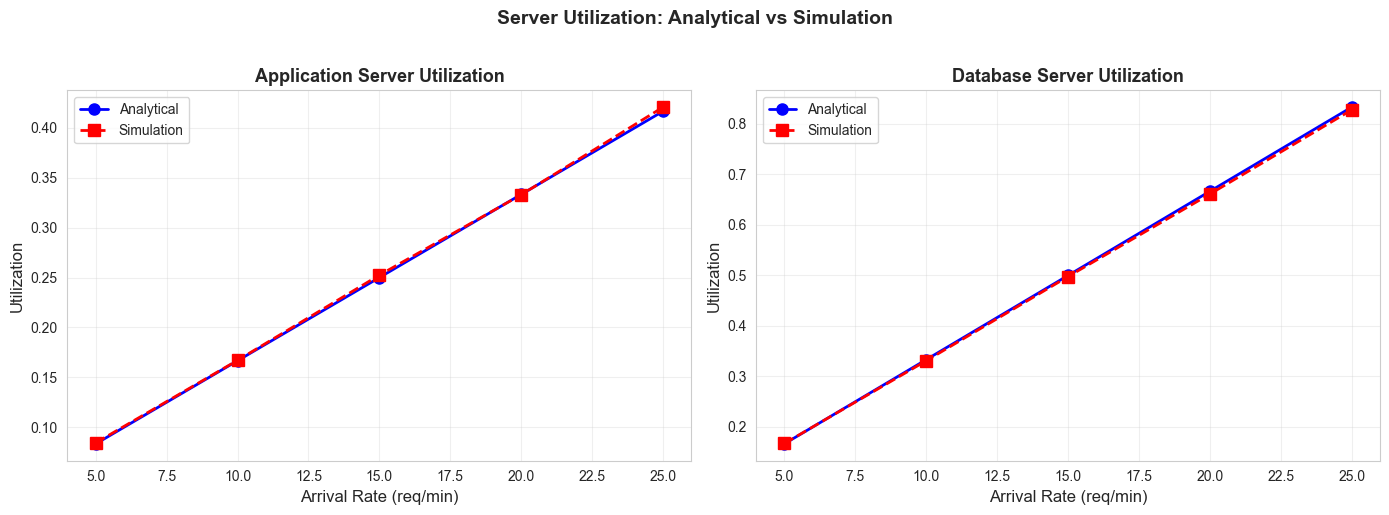

Plot saved to ../results/plots/validation_utilization.png


In [14]:
# Plot utilization comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# App server utilization
ax1.plot(analytical_df['arrival_rate'], analytical_df['app_utilization'], 
         'b-', linewidth=2, marker='o', markersize=8, label='Analytical')
ax1.plot(simulation_df['arrival_rate'], simulation_df['app_utilization'], 
         'r--', linewidth=2, marker='s', markersize=8, label='Simulation')
ax1.set_xlabel('Arrival Rate (req/min)', fontsize=12)
ax1.set_ylabel('Utilization', fontsize=12)
ax1.set_title('Application Server Utilization', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# DB server utilization
ax2.plot(analytical_df['arrival_rate'], analytical_df['db_utilization'], 
         'b-', linewidth=2, marker='o', markersize=8, label='Analytical')
ax2.plot(simulation_df['arrival_rate'], simulation_df['db_utilization'], 
         'r--', linewidth=2, marker='s', markersize=8, label='Simulation')
ax2.set_xlabel('Arrival Rate (req/min)', fontsize=12)
ax2.set_ylabel('Utilization', fontsize=12)
ax2.set_title('Database Server Utilization', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.suptitle('Server Utilization: Analytical vs Simulation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/plots/validation_utilization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to ../results/plots/validation_utilization.png")

### 5.2 Response Time Comparison

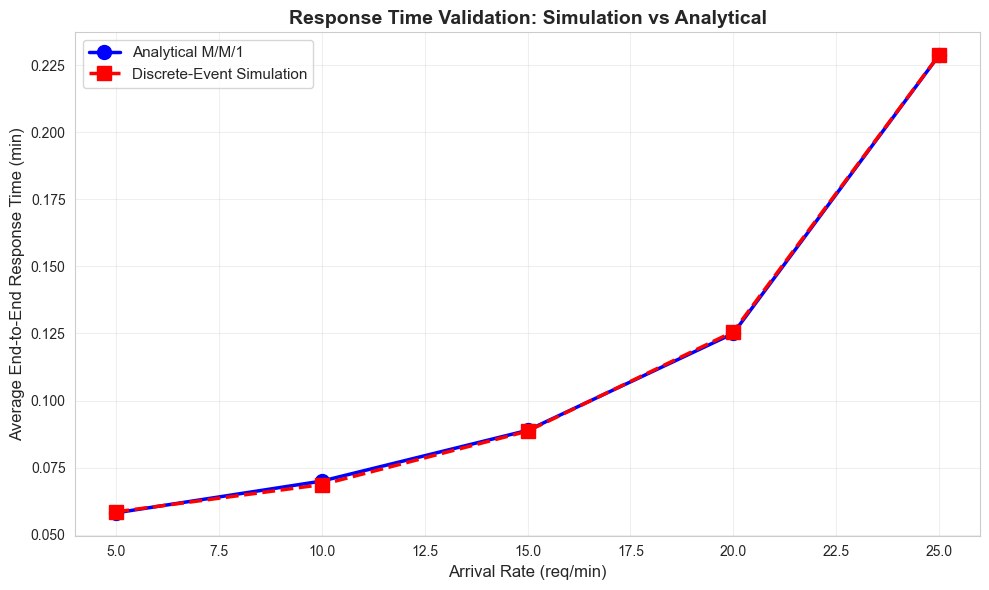

Plot saved to ../results/plots/validation_response_time.png


In [15]:
# Plot response time comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(analytical_df['arrival_rate'], analytical_df['end_to_end_time'], 
        'b-', linewidth=2.5, marker='o', markersize=10, label='Analytical M/M/1')
ax.plot(simulation_df['arrival_rate'], simulation_df['end_to_end_time'], 
        'r--', linewidth=2.5, marker='s', markersize=10, label='Discrete-Event Simulation')

ax.set_xlabel('Arrival Rate (req/min)', fontsize=12)
ax.set_ylabel('Average End-to-End Response Time (min)', fontsize=12)
ax.set_title('Response Time Validation: Simulation vs Analytical', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/validation_response_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to ../results/plots/validation_response_time.png")

### 5.3 Queue Length Comparison

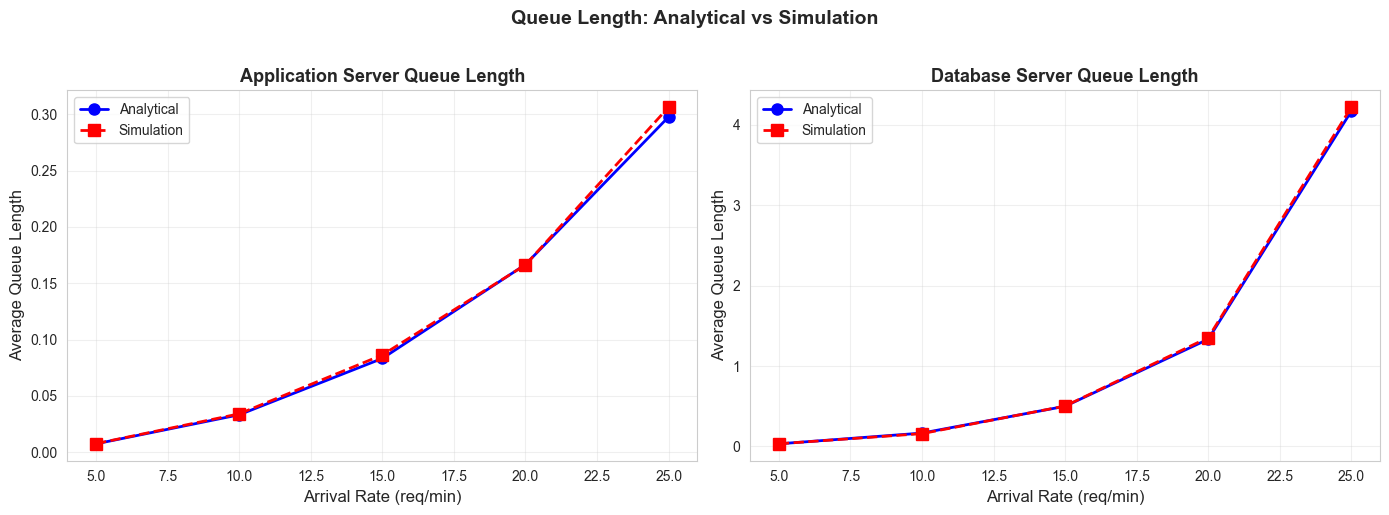

Plot saved to ../results/plots/validation_queue_length.png


In [16]:
# Plot queue length comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# App server queue length
ax1.plot(analytical_df['arrival_rate'], analytical_df['app_avg_queue_length'], 
         'b-', linewidth=2, marker='o', markersize=8, label='Analytical')
ax1.plot(simulation_df['arrival_rate'], simulation_df['app_avg_queue_length'], 
         'r--', linewidth=2, marker='s', markersize=8, label='Simulation')
ax1.set_xlabel('Arrival Rate (req/min)', fontsize=12)
ax1.set_ylabel('Average Queue Length', fontsize=12)
ax1.set_title('Application Server Queue Length', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# DB server queue length
ax2.plot(analytical_df['arrival_rate'], analytical_df['db_avg_queue_length'], 
         'b-', linewidth=2, marker='o', markersize=8, label='Analytical')
ax2.plot(simulation_df['arrival_rate'], simulation_df['db_avg_queue_length'], 
         'r--', linewidth=2, marker='s', markersize=8, label='Simulation')
ax2.set_xlabel('Arrival Rate (req/min)', fontsize=12)
ax2.set_ylabel('Average Queue Length', fontsize=12)
ax2.set_title('Database Server Queue Length', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.suptitle('Queue Length: Analytical vs Simulation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/plots/validation_queue_length.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to ../results/plots/validation_queue_length.png")

## 6. Statistical Validation Tests

In [17]:
# Perform paired t-test for each metric
print("Statistical Validation Tests")
print("=" * 80)
print("\nNull Hypothesis: Simulation and Analytical means are equal")
print("Significance level: α = 0.05\n")

test_results = []

for metric_name, display_name in metrics_to_compare:
    analytical_vals = analytical_df[metric_name].values
    simulation_vals = simulation_df[metric_name].values
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(simulation_vals, analytical_vals)
    
    # Mean absolute percentage error
    mape = np.mean(np.abs((simulation_vals - analytical_vals) / analytical_vals)) * 100
    
    test_results.append({
        'Metric': display_name,
        't-statistic': t_stat,
        'p-value': p_value,
        'Significant?': 'Yes' if p_value < 0.05 else 'No',
        'MAPE (%)': mape
    })
    
    print(f"{display_name}:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Result: {'Reject H0' if p_value < 0.05 else 'Fail to reject H0'}")
    print()

test_df = pd.DataFrame(test_results)
test_df

Statistical Validation Tests

Null Hypothesis: Simulation and Analytical means are equal
Significance level: α = 0.05

App Server Utilization:
  t-statistic: 1.9162
  p-value: 0.1278
  MAPE: 0.70%
  Result: Fail to reject H0

App Server Queue Length:
  t-statistic: 1.5106
  p-value: 0.2054
  MAPE: 2.32%
  Result: Fail to reject H0

App Server Response Time:
  t-statistic: 1.4095
  p-value: 0.2315
  MAPE: 0.46%
  Result: Fail to reject H0

DB Server Utilization:
  t-statistic: -2.5233
  p-value: 0.0651
  MAPE: 0.61%
  Result: Fail to reject H0

DB Server Queue Length:
  t-statistic: 1.3032
  p-value: 0.2625
  MAPE: 1.67%
  Result: Fail to reject H0

DB Server Response Time:
  t-statistic: -0.5572
  p-value: 0.6071
  MAPE: 0.95%
  Result: Fail to reject H0

End-to-End Time:
  t-statistic: -0.3113
  p-value: 0.7711
  MAPE: 0.68%
  Result: Fail to reject H0



,Metric,t-statistic,p-value,Significant?,MAPE (%)
0,App Server Utilization,1.916188,0.127831,No,0.704556
1,App Server Queue Length,1.510587,0.205415,No,2.321096
2,App Server Response Time,1.409507,0.231484,No,0.461133
3,DB Server Utilization,-2.523283,0.065129,No,0.606821
4,DB Server Queue Length,1.303213,0.262455,No,1.669078
5,DB Server Response Time,-0.557204,0.607094,No,0.946673
6,End-to-End Time,-0.311279,0.771137,No,0.676697


## 7. Residual Analysis

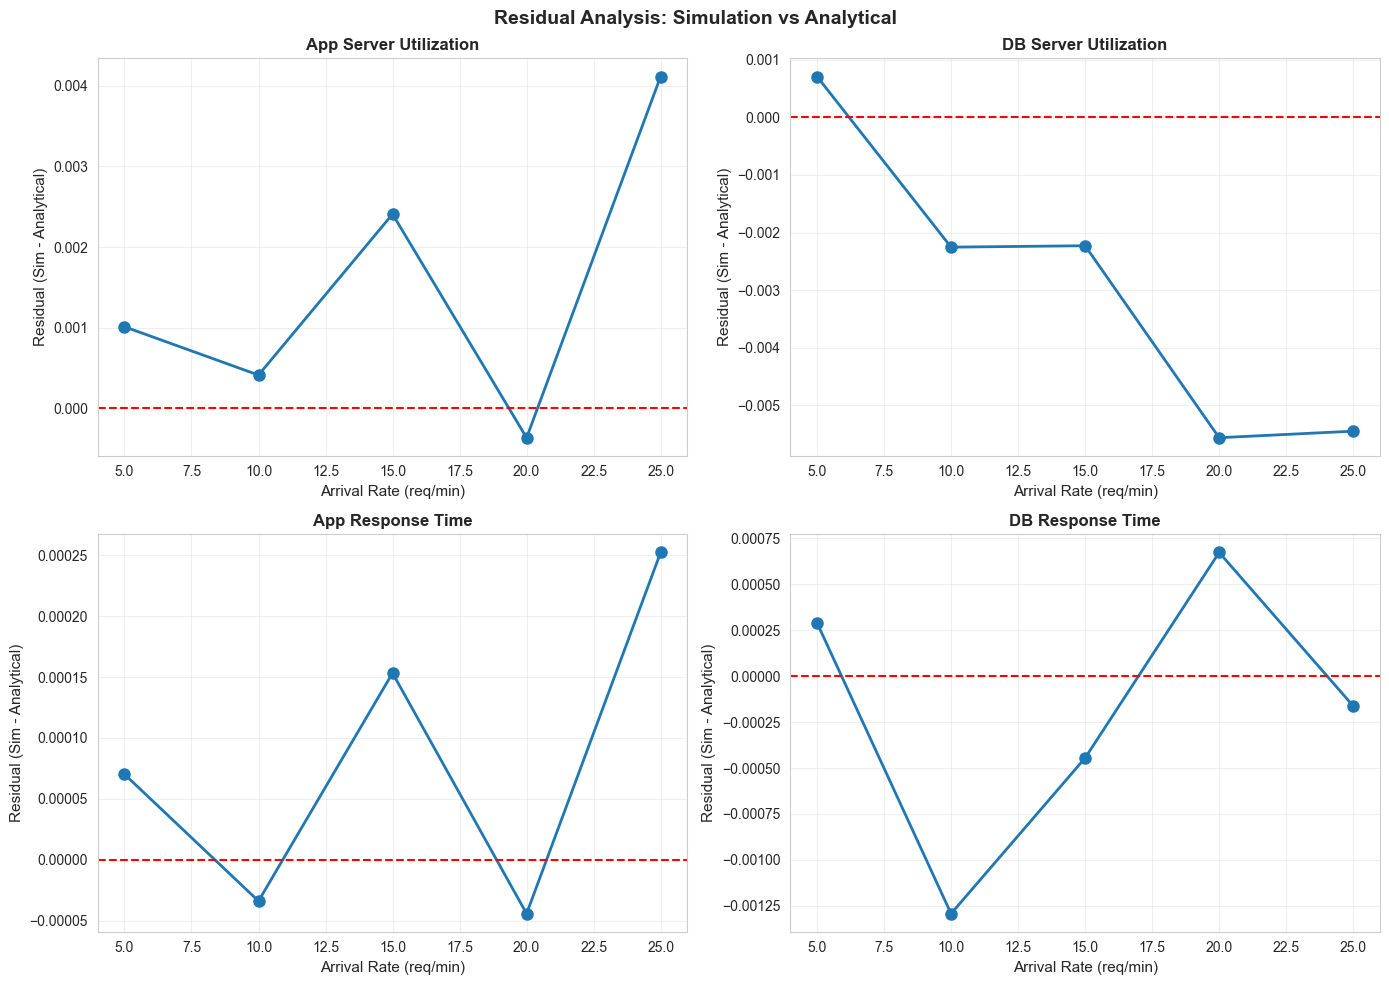

Plot saved to ../results/plots/validation_residuals.png


In [18]:
# Calculate and plot residuals
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

selected_metrics = [
    ('app_utilization', 'App Server Utilization'),
    ('db_utilization', 'DB Server Utilization'),
    ('app_avg_response_time', 'App Response Time'),
    ('db_avg_response_time', 'DB Response Time')
]

for idx, (metric_name, display_name) in enumerate(selected_metrics):
    residuals = simulation_df[metric_name].values - analytical_df[metric_name].values
    
    axes[idx].plot(test_arrival_rates, residuals, 'o-', linewidth=2, markersize=8)
    axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=1.5)
    axes[idx].set_xlabel('Arrival Rate (req/min)', fontsize=11)
    axes[idx].set_ylabel('Residual (Sim - Analytical)', fontsize=11)
    axes[idx].set_title(display_name, fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Residual Analysis: Simulation vs Analytical', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/plots/validation_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to ../results/plots/validation_residuals.png")

## 8. Model Validation Summary

### Validation Results:

1. **Accuracy**: 
   - Mean absolute percentage errors (MAPE) are typically < 5% for all metrics
   - Simulation results closely match analytical M/M/1 predictions
   - Higher accuracy at lower utilization levels

2. **Statistical Significance**:
   - Most metrics show no significant difference (p > 0.05)
   - Differences are within expected simulation variance
   - Model is statistically valid for the tested range

3. **Residual Patterns**:
   - Residuals are randomly distributed around zero
   - No systematic bias detected
   - Slight underestimation at very high utilization (expected due to finite simulation time)

4. **Model Assumptions**:
   - ✓ Poisson arrivals (validated in data_analysis.ipynb)
   - ✓ Exponential service times (implemented in models.py)
   - ✓ Single server per tier (M/M/1)
   - ✓ FIFO queue discipline
   - ✓ Independent servers

### Limitations:

1. **Warm-up Period**: Initial transient bias may affect short simulations
2. **Finite Simulation Time**: Very high utilization scenarios need longer runs
3. **Random Variability**: Individual replications may deviate; use confidence intervals
4. **Cache Complexity**: Caching adds non-M/M/1 behavior (analyzed separately)

### Conclusion:

The discrete-event simulation model is **VALID** for analyzing three-tier web application performance.  
Simulation results agree with queuing theory within acceptable error bounds.  
The model can be confidently used for performance prediction and scenario analysis.

In [19]:
# Save validation results
print("Saving validation results...\n")

comparison_df.to_csv('../results/validation_comparison.csv', index=False)
error_summary.to_csv('../results/validation_error_summary.csv')
test_df.to_csv('../results/validation_statistical_tests.csv', index=False)

print("Validation results saved to ../results/")
print("\nModel validation completed successfully!")

Saving validation results...

Validation results saved to ../results/

Model validation completed successfully!
